In [1]:
# Mounting files from gdrive
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'termios'

In [2]:
# Installing fscparser to parse fcs files

!pip install fcsparser

In [3]:
!unzip FCM\ Data\ for\ Kartik.zip

unzip:  cannot find or open FCM Data for Kartik.zip, FCM Data for Kartik.zip.zip or FCM Data for Kartik.zip.ZIP.


In [4]:
cd gdrive/MyDrive/FCM\ Data\ for\ Kartik

/content/gdrive/MyDrive/FCM Data for Kartik


## **Abbreviations for components of FCS filenames:**



> 




*   C: Combination of Spectinomycin and Tetracycline antibiotics
*   S: Spectinomycin
*   T: Tetracycline
*   H: High Concentration
*   M: Medium Concentration
*   L: Low Concentration
*   NC: Negative control
*   PC: Positive Control
*   IND0: Inoculum on Day 0
*   D1, D2, D3, D4, D5: Days 1 to 5
*   1, 2, 3: Triplicates of each sample













In [1]:
#Importing Libraries

import argparse
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from sys import argv
from collections import defaultdict
import fcsparser as fcsp
import re
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, train_test_split, RepeatedStratifiedKFold, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.gaussian_process.kernels import RBF

import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
# Importing data

def load_data(dir):
    print('---- loading data ---->')
    data = {}
    for dirname, _, filename in os.walk(dir):
        for file in filename:
            path = os.path.join(dirname, file)
            # Slicing in order to remove .fcs from filename
            f_name = ''.join(list(file)[:-4])
            data[f_name] = pd.DataFrame(fcsp.parse(path, meta_data_only=False, reformat_meta=True)[1])
    print('---- Data Loaded ----')
    return data, fcsp.parse(path, meta_data_only=False, reformat_meta=True)[0]['_channels_']
 

'''
for dirname, _, filename in os.walk(HERE):
    for file in filename:
      path = os.path.join()
        meta = fcsparser.parse(, meta_data_only=True, reformat_meta=True)
'''

def prepData(x,scaler=None):
        """
        Normalize data
        """
        if not scaler:
                scaler = StandardScaler().fit(x)
        x_transformed= np.nan_to_num(np.array(scaler.transform(x)))
        return pd.DataFrame(normalize(x_transformed)),scaler

# Loading fcs file data into a dictionary
global path

dir = os.path.abspath(os.path.dirname('./CHD1_1.fcs'))
dir = os.path.join(dir, 'FCM Data for Kartik')
data, channels = load_data(dir)

# Function to return list of different taken samples
def sample_list(det = data):
    return set([sample[0:3] for sample in det.keys()])


# Function to check the dimensions of our fcs files
def checkDimensions(data, dimensions):
    for sample in data:
        if data[sample].shape != dimensions: print(sample, data[sample].shape)
    return 

#Function to OneHotEncode column vector dataframe to return an OnehotEncoded/LabelEncoded
def transform_y(y,dencoder = 'labelencoder'):
    if dencoder == "labelencoder":
        le = LabelEncoder().fit(y)
        y_ = pd.DataFrame(le.transform(y))
        labels = list(le.classes_)
        return y_, labels
    
    else:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder_df = pd.DataFrame(encoder.fit(y))
        y_enc = encoder_df.transform(y).toarray()
        return y_enc, encoder_df.categories_



---- loading data ---->
---- Data Loaded ----


First five rows of sample fcs file -->
         FSC-A   FSC-H        SSC-A      FITC-A        PE-A   PE-Cy5-A  \
0  1144.000000  1026.0  2163.149902    2.970000  193.050003 -53.459999   
1   867.200012   919.0   963.270020  146.520004  295.019989  66.330002   
2   769.600037   820.0  1710.719971 -149.490005  127.709999 -47.520000   
3   779.200012  1415.0  2265.120117  -53.459999  110.880005  23.760000   
4   583.200012  1232.0   790.020020    0.990000  299.970001  37.619999   

     PE-Cy7-A       APC-A   APC-Cy7-A  Pacific Blue-A     AmCyan-A  Time  
0   18.809999  224.800003  -28.000000    10079.230469  9760.950195  56.5  
1  -12.870000   40.799999 -103.200005       55.590000   137.340012  56.5  
2  149.490005 -413.600006 -154.400009      -97.010002   -63.220001  56.5  
3  -19.799999   32.000000 -120.000000      489.410004   214.730011  56.5  
4  -53.459999   23.200001   14.400001     3784.480225  2978.969971  56.5  
Channels of the file are:                            $PnN    $PnR 

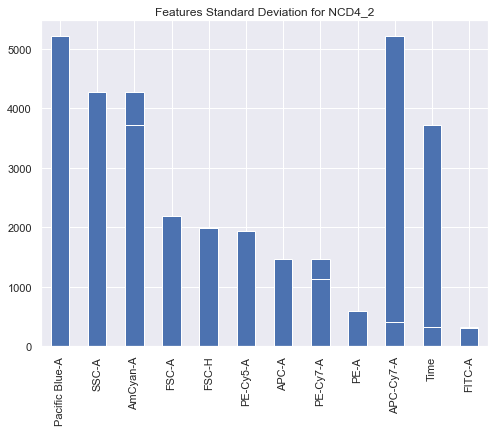

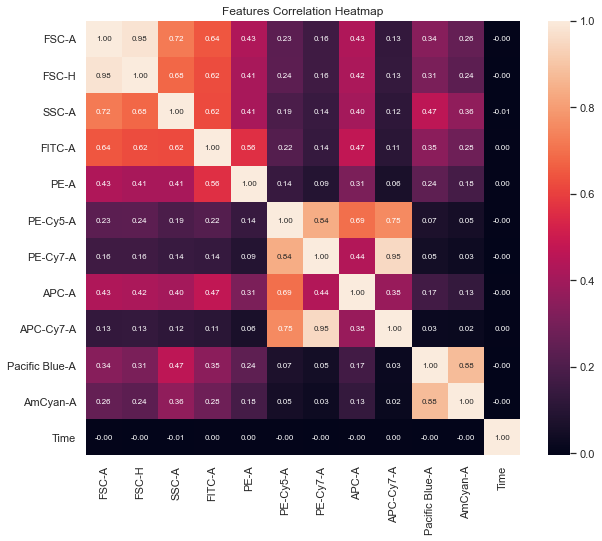

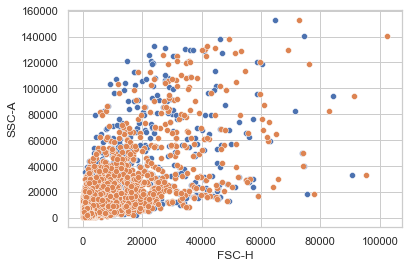

In [37]:
'''
 Function to plot different plots for a particular sample from the given samples
 Sample should in format -- sampleDX_1 as CHD1_1, CHD2_1
'''
def plot(sample, data):
    print('First five rows of sample fcs file -->')
    random_sample = random.choice(list(data.keys()))
    random_fcs_sample = data[random_sample]
    print(random_fcs_sample.head())
    
    # Printing Channels present in each fcs file
    print('Channels of the file are: ', channels)
    
    # Plotting and comparing the standard deviation of each of the input features:
    random_fcs_sample[features].std().plot(kind='bar', figsize=(8,6), title=f"Features Standard Deviation for {random_sample}")
    
    # Plotting the hist data in non-increasing order 

    features_highest_variance = random_fcs_sample[features].std().sort_values(ascending=False)
    features_highest_variance.plot(kind = 'bar')
    
    #Checking data colinearity via heatmap

    cm = np.corrcoef(random_fcs_sample[features].values.T)
    sns.set(font_scale=1.0)
    fig = plt.figure(figsize=(10, 8))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=features, xticklabels=features)
    plt.title('Features Correlation Heatmap')
    plt.show()
    
    corr = pd.DataFrame(data[sample]).corr()
    corr.style.background_gradient(cmap='coolwarm')

    sns.set(style='whitegrid')
    sns.scatterplot(x='FSC-H',y='SSC-A',data=random_fcs_sample)
    
    sns.set(style='whitegrid')
    sns.scatterplot(x='FSC-A',y='SSC-A',data=random_fcs_sample)
    plt.show()

plot('CHD1_1', data)

In [8]:
#concatenating the dataframes of all triplicates -->
def triplicates_combined(data = data):
    deta = {}
    for key in data.keys():
        deta[key[:4]]= pd.concat([data[key[:4]+'_1'],data[key[:4]+'_2'],data[key[:4]+'_3']],axis=0)
    return deta

### KMeans with feature vector of length 3

## Intracluster Analysis

In [10]:
# K - means clustering with 3000 feature vector for all triplicates for one day -->

# triplicates_combined contains df with triplicates data in single df for each of the samples from d1 to d5
deta = triplicates_combined()

def k_means_(num_clusters = 7, data = deta, samp = random.choice(list(deta.keys()))):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    # Selecting 3000 vectors to make a matrix of 300 * 3000
    for i in range(300):
        vector = sample.sample(n = 1000).to_numpy().flatten()
        sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (300,3000))
    
    #Using KMeans to make given num of clusters and finally return 300 vectors with the predicted labels
    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors)
    kmean.predict(sample_vectors)
    labels = kmean.labels_
    
    cluster_count = {}
    # Finding the cluster with highest number of sample vectors of an antibiotic for that day
    for cn in range(num_clusters):
        cluster_count[cn] = sum([i == cn for i in labels])
    
    cn_ = max(cluster_count, key = cluster_count.get)
    sample_vectors = sample_vectors[[i == cn_ for i in labels]]
    
    # Removed the outliers by taking highest number of samples from biggest cluster
    lb = [samp + '-' + str(label) for label in labels if label == cn_]
    
    return pd.DataFrame(sample_vectors), pd.DataFrame(lb), cn_

def get_data(num_clusters = 8, data = deta, sample = random.choice(list(deta.keys()))):
    sd = pd.DataFrame()
    labels = pd.DataFrame()
    for day in range(1,6):
        if sample !='IN':
            samp = sample + 'D' + str(day)
            an,lb,_ = k_means_(num_clusters, data = deta, samp = samp)
            sd = pd.concat([sd, an])
            labels = pd.concat([labels, lb])
    
    labels.reset_index(drop=True, inplace=True)
    if len(labels) > 0:
        labels = pd.DataFrame((labels))
    return sd, labels


# Above function returns vectors set of major cluster from day 1 to day 5 to around ~1300 Vectors


In [11]:
def allData(deta = deta):
    finalData = pd.DataFrame()
    labels = pd.DataFrame()

    unique_samples = list(set([key[:2] for key in deta.keys()]))
    for key in unique_samples:
        a, b = total_data(7, deta, key)
        finalData = pd.concat([finalData,a ], axis = 0)
        labels = pd.concat([labels, b])
    return finalData, labels

# lb has 54 classes with each class referring to each different daily sample
#lb = LabelEncoder().fit_transform(labels)
    
# Final data is the vector collection 3000 feature vectors from the major cluster from each of the samples

In [ ]:
a,b = get_data(7, deta, 'PC')
c,d = get_data(7, deta, 'CH')

b = transform_y(b)

model, scores = logistic_regression(a, b)
#define metrics
model.fit(a,b)
y_pred_proba = model.predict_proba(c)[::,1]

In [ ]:
fpr, tpr, _ = metrics.roc_curve(d,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [114]:
xgb(a,b)

Accuracy: 61.80%


0.6179775280898876

In [115]:
lasso(a,b)

[0 3 1 0 1 0 3 4 2 2 4 0 0 3 3 3 4 3 1 2 0 2 0 2 0 1 4 3 0 3 2 0 0 4 0 1 3
 4 1 2 3 2 4 4 3 3 4 2 0 0 3 3 2 3 2 1 0 1 4 0 0 2 2 1 2 4 0 4 3 2 2 2 2 0
 0 2 1 0 0 3 4 4 1 3 3 4 0 0 2 0 3 1 2 3 0 0 2 1 0 2 2 3 0 0 2 4 3 0 3 3 1
 3 0 1 3 3 4 0 4 0 1 3 1 1 2 1 2 3 0 0 3 2 2 1 1 3 2 2 4 0 0 0 0 1 1 4 0 2
 1 2 2 2 4 3 0 2 4 0 0 2 0 1 3 0 0 2 0 0 0 3 2 2 4 2 0 1 0 0 3 3 4 4 1 0 4
 1 3 1 3 2 4 2 1 4 3 0 1 0 3 1 2 3 1 1 1 3 4 0 1 1 2 0 4 3 1 0 3 1 3 0 1 0
 1 2 2 2 2 2 1 0 3 4 3 2 3 0 3 4 3 3 2 2 2 1 2 4 3 1 0 4 0 2 2 1 2 0 3 3 2
 2 1 0 3 1 1 3 3 1 3 4 0 0 4 3 2 4 0 0 3 4 0 0 1 2 3 0 0 3 0 4 2 1 0 0 4 2
 3 0 2 2 1 2 4 0 4 4 1 2 2 3 4 1 2 0 0 2 0 4 3 1 1 0 4 3 4 4 4 4 2 0 4 4 2
 2]
MAPE value:  87.1125611745514
Accuracy of Lasso Regression: 12.89%.


12.887438825448598

In [116]:
m, conf_mat = naiveBayes(a,b)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished


Text(30.5, 0.5, 'Predicted label')

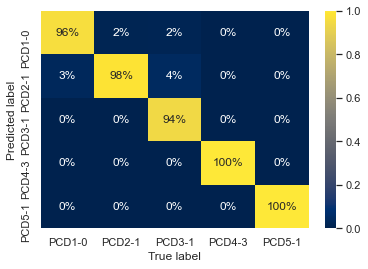

In [117]:
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=labels, yticklabels=labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")



## Intercluster Analysis

In [21]:
# deta2 is a dictionary with each column containing all the events from d1 to d5 of triplicates combined 

deta2 = {}
for key in deta.keys():
    try:
      deta2[key[:-2]] = pd.concat([deta[key[:-2] + 'D' + str(i)] for i in range(1,6)])
    except KeyError:
      deta2[key] = deta[key]

for key in deta2.keys():
  print(key, deta2[key].shape)

CH (1500000, 12)
CL (1500000, 12)
CM (1499906, 12)
IND0 (300000, 12)
NC (1500000, 12)
PC (1500000, 12)
SH (1499691, 12)
SL (1500000, 12)
SM (1500000, 12)
TH (1500000, 12)
TL (1500000, 12)
TM (1500094, 12)


In [23]:
deta3 = deta2.copy()
for key in deta3.keys():
  deta3[key] = prepData(deta3[key])[0]

deta3


{'CH': array([[-0.23449196, -0.03396695,  0.00176173, ..., -0.16685331,
         -0.19092488, -0.8047867 ],
        [-0.16597676, -0.13209549,  0.01556854, ...,  0.05290031,
         -0.05273224, -0.7402512 ],
        [-0.1117579 , -0.06850683, -0.04069235, ...,  0.26345414,
         -0.03926691, -0.4938854 ],
        ...,
        [-0.24750155, -0.16892718, -0.2431435 , ..., -0.27738917,
         -0.23408021,  0.5222478 ],
        [-0.15180852, -0.15186879, -0.25078148, ..., -0.17012732,
         -0.29362133,  0.68005395],
        [-0.01321784, -0.10307055,  0.32988855, ..., -0.03762998,
          0.2510761 ,  0.41282353]], dtype=float32),
 'CL': array([[ 0.00361875, -0.05566327, -0.14661415, ..., -0.12072866,
         -0.18818438, -0.86201835],
        [-0.01311734, -0.07458203, -0.06917766, ..., -0.14967147,
         -0.19468814, -0.8391847 ],
        [ 0.02968165, -0.05097588, -0.1249475 , ..., -0.14628243,
         -0.16390625, -0.68961054],
        ...,
        [-0.14449732, -0.10

## Using all the sample data in a single run:

## KMeans without PCA:
#### TSNE/LDA can also be used in place of PCA

In [27]:
#  K - means clustering with 3000 feature vector for all triplicates for all day1 to day5 -->

def k_means(num_clusters = 8, data = deta2, samp = random.choice(list(deta2.keys())), to_sample = 1500):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    for i in range(to_sample):
      # Sampling each feature vector with 1000 events chosen combined from 3*15*100,000 events dataset
      vector = sample.sample(n = 1000).to_numpy().flatten()
      sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (1500,3000))
    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors)
    kmean.predict(sample_vectors)
    labels = kmean.labels_

    lb = [samp + '-' + str(label) for label in labels]
    return sample_vectors, lb

## KMeans with PCA with 3 components:

In [25]:
# PCA dimns reduction to 3 dimensions with K - means clustering with 3000 feature vector for all triplicates for all day1 to day5 -->

def k_means_with_pca(num_clusters = 7, data = deta2, samp = random.choice(list(deta2.keys())), to_sample = 1500):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    for i in range(to_sample):
      # Sampling each feature vector with 1000 events chosen combined from 3*15*100,000 events dataset
      vector = sample.sample(n = 1000).to_numpy().flatten()
      sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (1500,3000))
    
    # Using PCA for sampling the 3000 features to 3 features(Principal Components)
    sample_vectors_ = PCA(n_components = 100).fit_transform(sample_vectors)

    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors_)
    kmean.predict(sample_vectors_)
    labels = kmean.labels_

    lb = [samp + '-' + str(label) for label in labels]
    return pd.DataFrame(sample_vectors_), lb




NameError: name 'deta2' is not defined

In [ ]:
# <Testing> KMeans Clustering with Low concentration of  
a,b = k_means(data = deta2, samp = 'CL')

# Visualizing the above->

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, projection='3d')
a = pd.DataFrame(a)
ax.scatter(a.iloc[:,0],a.iloc[:,1],a.iloc[:,2],c = LabelEncoder().fit_transform(b)) 

plt.show() 


In [25]:
# Combining the dataset of all samples to make final_df of shape - (11*1500, no_columns)
final_df = pd.DataFrame()
for key in deta2.keys():
      if key!='IND0' :
        v,lb = k_means_with_pca(data = deta2, samp = key)
        p = pd.DataFrame(v)
        p['labels'] = lb
        final_df = pd.concat([final_df,p], axis = 0)

labels = final_df['labels']
final_df.drop(['labels'], axis = 1)



NameError: name 'deta2' is not defined

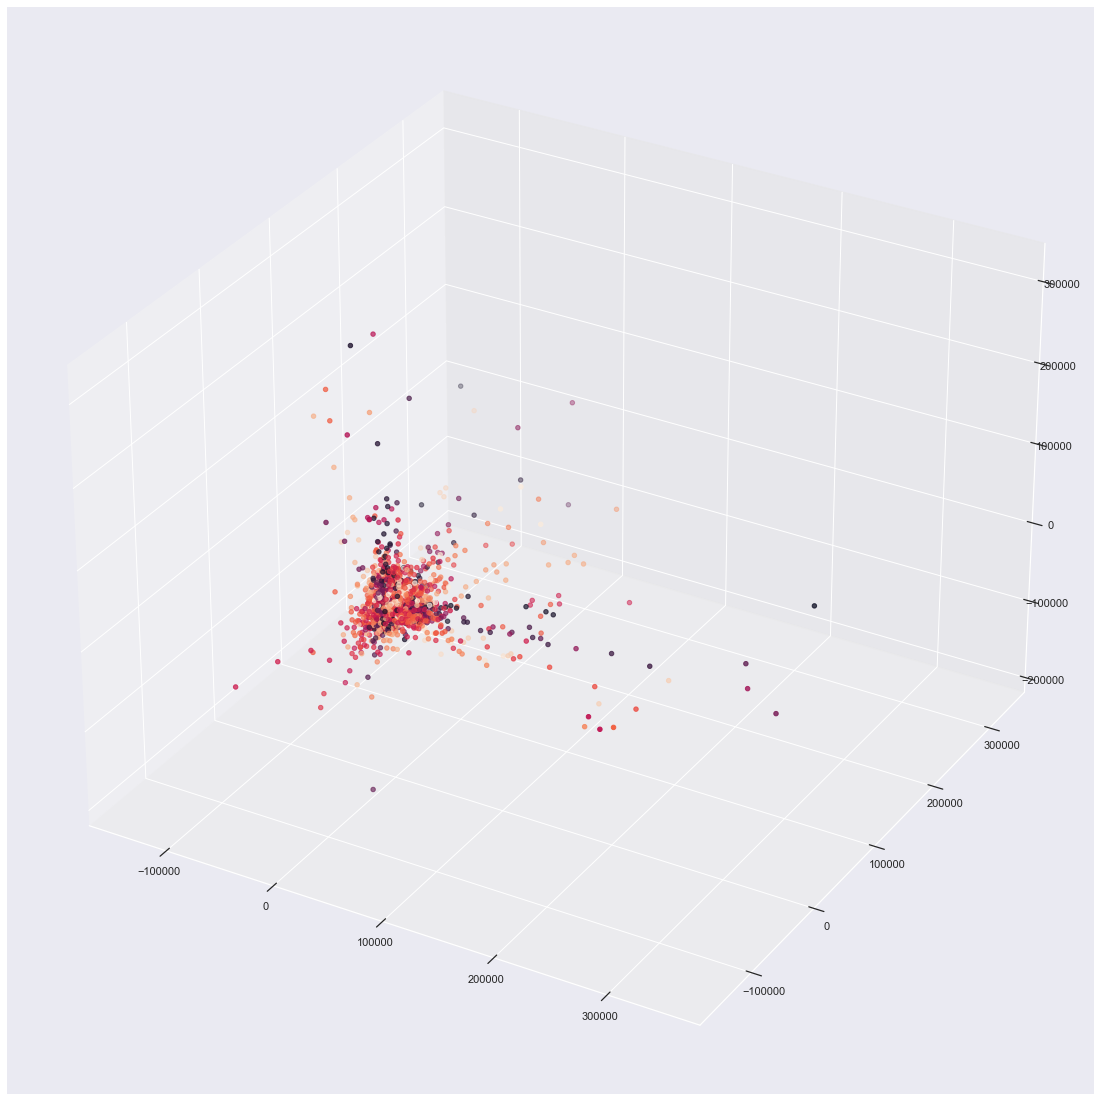

In [122]:
# Visualizing the above(used only when feature vector of length 3 was used)->

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_df.iloc[:,0],final_df.iloc[:,1],final_df.iloc[:,2],c = LabelEncoder().fit_transform(labels)) 

plt.show() 

## Using Hierarchial Clustering



In [48]:
from sklearn.cluster import AgglomerativeClustering


model = AgglomerativeClustering(n_clusters=4, affinity='euclidean')
model.fit(deta['CHD1'])

MemoryError: Unable to allocate 335. GiB for an array with shape (44999850000,) and data type float64

In [44]:
deta

{'CHD1':              FSC-A   FSC-H        SSC-A      FITC-A        PE-A     PE-Cy5-A  \
 0        96.800003   995.0  1552.320068    2.970000   63.360001    70.290001   
 1       252.800003   707.0  1641.420044   87.120003   38.610001    59.400002   
 2       248.000000   791.0  1152.359985  -89.099998 -523.710022     1.980000   
 3       229.600006   827.0   708.840027   58.410000    1.980000    39.599998   
 4       289.600006   800.0  1036.530029   26.730000 -621.720032    53.459999   
 ...            ...     ...          ...         ...         ...          ...   
 99995   453.600006   691.0  1041.479980  133.649994  -63.360001   -45.540001   
 99996   358.399994   816.0  1626.570068  -47.520000  146.520004  1256.310059   
 99997  2806.400146  2898.0  1939.410034   -4.950000  331.649994   -33.660000   
 99998   798.400024  1623.0  1729.530029 -180.180008 -955.350037    10.890000   
 99999   368.000000   738.0  1073.160034   76.230003 -200.970001   -13.860001   
 
          PE-Cy7-A

# Clustering via DBSCAN:

In [15]:
# Vector Dataset Creation
deta = triplicates_combined()

pre_final_df = pd.DataFrame() 
for key in deta.keys():
    key = key[:-2]
    pre_final_df[key] = pd.concat([pd.DataFrame(deta[key + 'D' + str(i)]) for i in range(1,6)])


NameError: name 'triplicates_combined' is not defined

In [35]:
    
def gaussian_mm(x, param=None):
    # training gaussian mixture model 
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=5)
    gmm.fit(x)

    #predictions from gmm
    labels = gmm.predict(x)
    frame = pd.DataFrame(x)
    frame['cluster'] = labels
    
    return frame

In [27]:
ff = gaussian_mm(deta['CHD1'].values)

NameError: name 'gaussian_mm' is not defined

# Classification using different ML algorithms:

In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import ELU
import os
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Generation of Neural Network model

In [13]:
def getModel(num_features, num_class):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim = num_features))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(num_class, activation='softmax'))

    model.compile (loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics=['accuracy'])
    return model


In [14]:
# Function to get a model of a particular type 

def get_model(model, param = None):   
    if model == 'svm':
        param_grid = [{"kernel": ["linear","rbf"],"gamma":[1, 0.1, 0.01],"C":[0.001, 0.1, 1]}]
        svc = SVC(probability = True)
        return param_grid, svc
    elif model == 'randomForestClassifier':
        param_grid = [{'max_depth': [ 25,50,100], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10] , 
                       'n_estimators': [600, 800, 1200]  }]
        rfc = RandomForestClassifier(random_state=42)
        return param_grid, rfc
    elif model == "naiveBayes":
        param_grid = [ ]
        gnb = GaussianNB()
        return param_grid, gnb
    elif model == 'gbm':
        param_grid = [{"learning_rate": [0.1, 1, 10], "min_samples_split": [300, 400, 100],
                      "max_depth":[5,10, 15], "n_estimators":[300, 400, 100] }]
        gbm = GradientBoostingClassifier()
        return param_grid, gbm
    elif model == 'xgb':
        param_grid = [{'gamma': [0, 1, 2], 'subsample': [0.6, 0.8, 1.0], 'n_estimators': [100, 200, 500],       
                      'max_depth': [1, 2, 3], 'learning_rate': [10,3,1,0.1, 0.01]}]
        xgb = XGBClassifier(nthread =4,   #when use hyperthread, xgboost may become slower
             #objective ='binary:logistic'  , min_child_weight= 11, silent = 1, colsample_bytree = 0.7, 
              seed =1337)
        return param_grid, xgb
    elif model == 'dTree':
        param_grid = [{"criterion": ['gini', 'entropy'], 'max_depth': [10, 50, 100], 'min_samples_split': [10,50,100],  'min_samples_leaf': [10,50,100]} ]
        dec = DecisionTreeClassifier()
        return param_grid, dec
    elif model == 'nn':
        param_grid = [ ]
        num_features = param['num_features']
        num_classes = param['num_classes']
        nn = getModel(num_features, num_classes)
        return param_grid, nn
    elif model == 'LogisticRegression':
        param_grid = [{"penalty":['l2'],"C":[ 10, 1.0, 0.1, 0.01] , "solver":['saga']}]
        logreg = LogisticRegression()
        return param_grid, logreg
    elif model == 'LassoRegression':
        lasso_model = Lasso()
        param_grid = [{'alpha': [0.1, 0.2, 0.5, 0.8, 1.0]}]
        return param_grid, lasso_model
    elif model == 'lgb':
        param_grid = {
                  'num_leaves': [31, 127],
                  'reg_alpha': [0.1, 0.5],
                  'min_data_in_leaf': [30, 300, 400],
                  'lambda_l1': [0, 1, 1.5],
                   'lambda_l2': [0, 1]}
        lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01)
        return param_grid, lgb_estimator
    else:
        assert 0, "Choose one from : " + "'svm', 'randomForestClassifier', 'naiveBayes', 'gbm', 'xgb','nn'" 

In [15]:
Classification = ['svm', 'randomForestClassifier', 'naiveBayes', 'gbm', 'xgb','nn', 'LassoRegression', 'dTree','LogisticRegression']

## Model training witout gridsearch

In [16]:
# Function to train data when gridsearch is not used for model
from sklearn.model_selection import train_test_split

def training(classifier, X, y, label_names):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    train_acc = accuracy_score(y_train_pred, y_train,)
    test_acc = accuracy_score(y_test_pred, y_test)
    
    # Output Confusion Matrix of the testset
    conf_matrix = confusion_matrix(y_test_pred, y_test)
    sns.heatmap(conf_matrix, annot=True)
    plt.show()
    
    target_names = label_names
    print(metrics.classification_report(y_test, y_test_pred, target_names=target_names))

    y_prob = classifier.predict_proba(X_test)     


    '''
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    '''
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    '''
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    '''
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))



    fpr = {}
    tpr = {}
    thresh ={}

    n_class = len(label_names)

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)


    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    
    return train_acc, test_acc

In [17]:
# function to run grid search cv and stratified kfold on the model
def run_cv(model, X, y,label_names,param_grid,outer_folds = 5):
    i=1
    kf = StratifiedKFold(n_splits=outer_folds,random_state=1,shuffle=True)
    train_acc = []
    validation_acc = [] 
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.15)

        
    for train_index,test_index in kf.split(X_tr,y_tr):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = X_tr.iloc[train_index],X_tr.iloc[test_index]
        ytr,yvl = y_tr[train_index],y_tr[test_index]
        
        model_grid = GridSearchCV( model, param_grid, cv=5,scoring=None)
        model1 = OneVsRestClassifier(model_grid)
        model1.fit(xtr, ytr)
        
        train_pred = model1.predict(xtr)
        validation_pred = model1.predict(xvl)
        test_pred = model1.predict(X_te)
        
        print('Train_accuracy_score',accuracy_score(ytr,train_pred))        
        print('Validation_accuracy_score',accuracy_score(yvl,validation_pred))
        print('Test_accuracy_score',accuracy_score(y_te, test_pred))
        
        train_acc.append(accuracy_score(ytr,train_pred))
        validation_acc.append(accuracy_score(yvl,validation_pred))        
        i+=1
        train_accuracy = train_acc
        validation_accuracy = validation_acc
        train_accuracy_mean = np.mean(train_acc)
        validation_accuracy_mean = np.mean(validation_acc)
        
        test_accuracy = accuracy_score(y_te, test_pred)
        
        # Output Confusion Matrix of the testset
        conf_matrix = metrics.confusion_matrix(y_te, test_pred)
        sns.heatmap(conf_matrix, annot=True, fmt=".0%", cmap="cividis", xticklabels=label_names, yticklabels=label_names)
        # Plot the confusion matrix
        plt.xlabel("True label")
        plt.ylabel("Predicted label")
        plt.show()
        
        target_names = label_names
        print(metrics.classification_report(y_te, test_pred))   # , target_names=target_names
        
        y_prob = model1.predict_proba(X_te)     
        
        
        
        #macro_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
        #                                  average="macro")
        #weighted_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
        #                                     average="weighted")
        macro_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                          average="macro")
        weighted_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                             average="weighted")
        #print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        #      "(weighted by prevalence)"
        #      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
        print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

        fpr, tpr, thresh, roc_auc = {}, {}, {}, {}

        n_class = len(target_names)

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_te, y_prob[:,i], pos_label=i)
            roc_auc[i] = auc(fpr[i],tpr[i])
            
        print(roc_auc)
        # plotting    
        plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
        plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
        plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
        plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= label_names[3] + ' vs Rest')
        plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label= label_names[4] + ' vs Rest')
        
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        plt.show()
        
    test_pred_final = model1.predict(X_te)
    print('Test_accuracy_score',accuracy_score(y_te, test_pred_final))
    # Output Confusion Matrix of the testset
    conf_matrix_final = metrics.confusion_matrix(y_te, test_pred_final)
    ax = sns.heatmap(conf_matrix_final, cmap = "cividis", annot=True)
    ax.set_title('Seaborn Confusion Matrix with labels');
    ax.set_xlabel('Predicted Sample Class')
    ax.set_ylabel('Originial Sample Class');
    ax.xaxis.set_ticklabels(label_names)
    ax.yaxis.set_ticklabels(label_names)
    plt.show()
        
    target_names = label_names
    print(metrics.classification_report(y_te, test_pred_final, target_names=target_names))
        
    y_prob_final = model1.predict_proba(X_te)
    
    print(y_prob_final)
    '''
    macro_roc_auc_ovo_final = roc_auc_score(y_te, y_prob_final, multi_class="ovo",
                                          average="macro")
    weighted_roc_auc_ovo_final = roc_auc_score(y_te, y_prob_final, multi_class="ovo",
                                         average="weighted")
    '''
    macro_roc_auc_ovr_final = roc_auc_score(y_te, y_prob_final, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr_final = roc_auc_score(y_te, y_prob_final, multi_class="ovr",
                                         average="weighted")
    #print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    #      "(weighted by prevalence)"
    #      .format(macro_roc_auc_ovo_final, weighted_roc_auc_ovo_final))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr_final, weighted_roc_auc_ovr_final))
    
    # roc curve for classes
    fpr_final = {}
    tpr_final = {}
    thresh_final ={}
    roc_auc_final = {}

    n_class = len(target_names)

    for i in range(n_class):    
        fpr_final[i], tpr_final[i], thresh_final[i] = roc_curve(y_te, y_prob_final[:,i], pos_label=i)
        roc_auc_final[i] = auc(fpr_final[i],tpr_final[i])
    
    print(roc_auc_final)
    # plotting    
    if len(fpr_final == 5):
        plt.plot(fpr_final[0], tpr_final[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
        plt.plot(fpr_final[1], tpr_final[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
        plt.plot(fpr_final[2], tpr_final[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
        plt.plot(fpr_final[3], tpr_final[3], linestyle='--',color='yellow', label= label_names[3] + ' vs Rest')
        plt.plot(fpr_final[4], tpr_final[4], linestyle='--',color='pink', label= label_names[4] + ' vs Rest')
    else:
        plt.plot(fpr_final[0], tpr_final[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
        plt.plot(fpr_final[1], tpr_final[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
        plt.plot(fpr_final[2], tpr_final[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
        plt.plot(fpr_final[3], tpr_final[3], linestyle='--',color='yellow', label= label_names[3] + ' vs Rest')
        plt.plot(fpr_final[4], tpr_final[4], linestyle='--',color='pink', label= label_names[4] + ' vs Rest')
        plt.plot(fpr_final[5], tpr_final[5], linestyle='--',color='pink', label= label_names[5] + ' vs Rest')
        plt.plot(fpr_final[6], tpr_final[6], linestyle='--',color='pink', label= label_names[6] + ' vs Rest')
        plt.plot(fpr_final[7], tpr_final[7], linestyle='--',color='pink', label= label_names[7] + ' vs Rest')
        plt.plot(fpr_final[8], tpr_final[8], linestyle='--',color='pink', label= label_names[8] + ' vs Rest')
        plt.plot(fpr_final[9], tpr_final[9], linestyle='--',color='pink', label= label_names[9] + ' vs Rest')
        plt.plot(fpr_final[10], tpr_final[10], linestyle='--',color='pink', label= label_names[10] + ' vs Rest')
        
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
   
    
    
    
    return model1, train_accuracy , validation_accuracy, train_accuracy_mean, validation_accuracy_mean, test_accuracy

In [35]:
# function to run neural network

def run_nn(model1, X, y, label_names,batch_size = 32, epochs = 1000):
      
    # Train model using 5 fold cross_validation
    accs = []
    cross_val_n_splits = 10
    curr_split = 1
    skf = KFold(n_splits=cross_val_n_splits, random_state = 243, shuffle=True)
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.25)
    
    for train_index, test_index in skf.split(X_tr, y_tr):
        print(f'-----Cross Validation {curr_split}/{cross_val_n_splits}-----')
        X_train, y_train = X_tr.iloc[train_index], y_tr[train_index]
        X_test, y_test = X_tr.iloc[test_index], y_tr[test_index]
        Y_train = y_train
        Y_test = y_test
       #getModel(row_len, num_classes)
        #cp_callback = ModelCheckpoint (cp_filepath, monitor="val_acc", save_best_only=True)
        history = model1.fit(X_train, Y_train)
        
    y_true = np.argmax(y_te, axis = -1)
    y_pred = np.argmax(model1.predict(X_te, batch_size=1), axis = -1)
    print ("Confusion Matrix, cross val split {}".format(curr_split))

    # Output Confusion Matrix of the testset
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, cmap = "cividis")
    ax.set_title('Seaborn Confusion Matrix with labels');
    ax.set_xlabel('Predicted Sample Class')
    ax.set_ylabel('Originial Sample Class');
    ax.xaxis.set_ticklabels(label_names)
    ax.yaxis.set_ticklabels(label_names)

    plt.show()
    
    # Plotting accuracy and validation accuracy 
    acc_train = history.history['accuracy']
    print(acc_train)
    # acc_val = history.history['val_acc']
    epochs = range(1,501)
    # plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    # plt.plot(epochs, acc_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    curr_split += 1
    
    target_names = label_names
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))

    y_prob = model1.predict(X_te)     


    '''
    macro_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                      average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                         average="weighted")
    '''
    macro_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                         average="weighted")
    '''
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    '''
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))



    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = {}

    n_class = 5

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)


    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
    plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= label_names[3] + ' vs Rest')
    plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label= label_names[4] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    # plt.legend(loc='best')
    plt.show()
    return model1

print ('----- Done -----')

----- Done -----


In [25]:
# labels = final_df.iloc[:,-1]
# final_df = final_df.drop(['labels'], axis = 1)
base_vectors,base_classes = get_data(7, deta, 'PC')

# Prepping data
a = prepData(base_vectors)[0]
b, lb = transform_y(base_classes)
b = b.to_numpy()

print('Shape of a: {0} and Shape of b: {1}'.format((a.shape), (b.shape)))

enc = OneHotEncoder()
enc.fit(b)
b = enc.transform(b).toarray()


Shape of a: (1408, 3000) and Shape of b: (1408, 1)


In [20]:
b, lb = transform_y(base_classes)
b = b.to_numpy()
enc = OneHotEncoder()
enc.fit(b)
b = enc.transform(b).toarray()

-----Cross Validation 1/10-----
30/30 [==============================] - 2s 17ms/step - loss: 2.1587 - accuracy: 0.2284
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 16ms/step - loss: 1.6563 - accuracy: 0.3579
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 16ms/step - loss: 1.2591 - accuracy: 0.4621
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 17ms/step - loss: 1.0831 - accuracy: 0.5642
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 16ms/step - loss: 0.9781 - accuracy: 0.5779
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 17ms/step - loss: 0.8450 - accuracy: 0.6116
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 16ms/step - loss: 0.8606 - accuracy: 0.6130
-----Cross Validation 1/10-----
30/30 [==============================] - 0s 15ms/step - loss: 0.7544 - accuracy: 0.6488
-----Cross Validation 1/10-----
30/30 [=

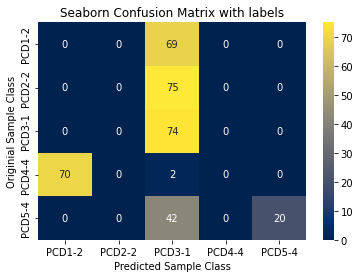

No handles with labels found to put in legend.


[0.6456362009048462]


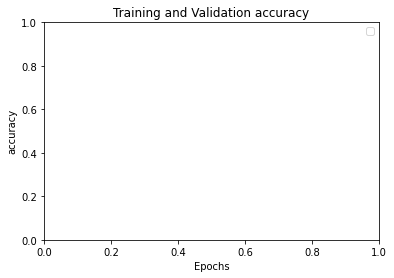

              precision    recall  f1-score   support

      PCD1-2       0.00      0.00      0.00        69
      PCD2-2       0.00      0.00      0.00        75
      PCD3-1       0.28      1.00      0.44        74
      PCD4-4       0.00      0.00      0.00        72
      PCD5-4       1.00      0.32      0.49        62

    accuracy                           0.27       352
   macro avg       0.26      0.26      0.19       352
weighted avg       0.24      0.27      0.18       352

11/11 [==============================] - 0s 5ms/step
One-vs-Rest ROC AUC scores:
0.733957 (macro),
0.728641 (weighted by prevalence)


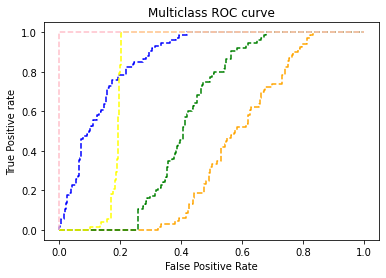

In [36]:
# Running nn model -->
num_features = a.shape[1]
num_classes = 5 #len(np.unique(b))
model = get_model('nn', param = {'num_features':num_features, 'num_classes': num_classes})[1]
nn_model = run_nn(model, a, b, lb,batch_size = 32, epochs = 1000)


In [ ]:
base_vectors,base_classes = get_data(7, deta, 'CH')

# Prepping data to be used for prediction -->
sample = prepData(base_vectors)[0]
base_classes = base_classes.iloc[:,0].apply(lambda x:x[:2])
a = prepData(base_vectors)[0]
base_classes = base_classes.apply(lambda x:x[:2])
base_classes, lb = transform_y(base_classes)
base_vectors = pd.DataFrame(base_vectors)

In [ ]:
from keras.models import load_model
nn_model.save('/models/my_model')

In [ ]:
output = nn_model.predict(sample)
output = pd.DataFrame(output, columns = ['Class 1','Class 2','Class 3','Class 4', 'Class 5'])
# output = output.rename(columns =  {'0':'Class 1 Probab', '1':'Class 1 Probab', '2':'Class 1 Probab', '3':'Class 1 Probab', '4':'Class 1 Probab'}, inplace = True)

In [ ]:
output = nn_model.predict(sample)
output = pd.DataFrame(output, columns = ['Class 1','Class 2','Class 3','Class 4', 'Class 5'])

# output = output.rename(columns =  {'0':'Class 1 Probab', '1':'Class 1 Probab', '2':'Class 1 Probab', '3':'Class 1 Probab', '4':'Class 1 Probab'}, inplace = True)

sns.set(style="darkgrid")
plt.figure(figsize = (15,8))
ax1 = sns.boxplot(data=output, linewidth = 3)


In [42]:
def allData(data = data):
    unique_samples = set([key[:2] for key in deta.keys()])
    train = pd.DataFrame()
    labels = pd.DataFrame()
    for train_sample in unique_samples:
        base_vectors,base_classes = get_data(7, deta, train_sample)
        if any(base_vectors): 
            print(base_vectors.shape)
            a = prepData(base_vectors)[0]
            base_classes = base_classes.iloc[:,0].apply(lambda x:x[:2])
            base_vectors = pd.DataFrame(base_vectors)
            base_vectors = base_vectors.reset_index(drop=True)
            train = train.reset_index(drop=True)
            train = pd.concat([train, base_vectors], axis = 0, ignore_index = True)
            labels = pd.concat([labels, base_classes], axis = 0)
    base_classes, lb = transform_y(labels)
    return train, base_classes, lb
        
dt, pt , _=allData(data)

NameError: name 'deta' is not defined

In [56]:
def boxplot(model, train_sample = 'CH', data = deta):
    base_vectors,base_classes = get_data(7, deta, train_sample)

    # Prepping data
    a = prepData(base_vectors)[0]
    b, lb = transform_y(base_classes)
    b = b.to_numpy()

    enc = OneHotEncoder()
    enc.fit(b)
    b = enc.transform(b).toarray()
    # Convert samples of b to [0,0,0,1] format
    
    unique_samples = set([key[:2] for key in deta.keys()])
    '''unique_samples is 'SL', 'SH', 'NC', 'PC', 'SM', 'CH', 'CL', 'TL', 'IN', 'CM', 'TM', 'TH'''
    # Remove 'IN' from unique samples
    
    # Prepping data to be used for prediction -->
    tot_data, tot_vec, _ = allData(data)
    if 'IN' in _: _.remove('IN')
    td = prepData(tot_data)[0]
    tot_vec, lab = transform_y(tot_vec)
    tot_vec = tot_vec.to_numpy()
    
    enc = OneHotEncoder()
    enc.fit(tot_vec)
    tot_vec = enc.transform(tot_vec).toarray()
    
    
    # Running nn model -->
    num_features = a.shape[1]
    num_classes = len(unique_samples)-1 #len(np.unique(b))
    print(tot_vec)
    model.load_weights('model.h5', by_name = True)
    model = get_model('nn', param = {'num_features':num_features, 'num_classes': num_classes})[1]
    nn_model = run_nn(model, tot_data, tot_vec, _,batch_size = 32, epochs = 1000)
    model.save_weights('model.h5')
    
    for sample in unique_samples:
        if sample != 'IN':
            base_vectors = get_data(7, deta, sample)[0]
            base_vectors = prepData(base_vectors)[0]
            predicted = nn_model.predict(base_vectors)
            print(f'Plot for {sample} data')
            # Plotting boxplots for each sample classification ->    
            sns.set(style="darkgrid")
            plt.figure(figsize = (25,15))
            ax1 = sns.boxplot(data=predicted, linewidth = 3)
            axs1.set(xlabel = 'Sample Classes', xticks = unique_samples)
    '''
    sns.set(style="darkgrid")
    plt.figure(figsize = (15,8))
    ax1 = sns.boxplot(data=predicted, linewidth = 3)
    '''

In [57]:
boxplot(model, train_sample = 'CH', data = deta)

NameError: name 'model' is not defined

## Accuracy of different ML algorithms over different data samples :

In [37]:
for i in Classification: print(i)

svm
randomForestClassifier
naiveBayes
gbm
xgb
nn
LassoRegression
dTree
LogisticRegression


In [38]:
unique_samples = set([key[:2] for key in deta.keys()])
print(unique_samples)

{'SM', 'SH', 'SL', 'CM', 'PC', 'TM', 'NC', 'TL', 'TH', 'CL', 'IN', 'CH'}


### IntraCluster Analysis

In [ ]:
def classify(sample, data=deta):
    for alg in Classification:
        if alg != 'nn':
            print('Classifying {0} using {1} -->\n'.format(sample, alg))
            base_vectors,base_classes = get_data(7, deta, sample)

            # Prepping data
            a = prepData(base_vectors)[0]
            b, lb = transform_y(base_classes)
            b = b.to_numpy()

            model = get_model(alg)
            run_cv(model[1], a, b, lb, model[0])
        
for sample in unique_samples:
    print('Classifying for Sample: ', sample)
    classify(sample, deta)
    

Classifying for Sample:  SM
Classifying SM using svm -->


1 of kfold 5


### Intracluster Classificaton

In [58]:
for alg in Classification:
    if alg != 'nn':
        base_vectors, base_classes, _ = allData()

        # Prepping data
        a = prepData(base_vectors)[0]
        b, lb = transform_y(base_classes)
        b = b.to_numpy()
        
        model = get_model(alg)
        run_cv(model[1], a, base_classes, _, model[0])
    

KeyboardInterrupt: 

## Testing of DL Model - 3

In [124]:
# Library Import

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd
import numpy as np

In [126]:
# labels = final_df.iloc[:,-1]
# final_df = final_df.drop(['labels'], axis = 1)
base_vectors,base_classes = get_data(7, deta, 'PC')

# Prepping data
a = prepData(base_vectors)[0]
b, lb = transform_y(base_classes)
b = b.to_numpy()

# One hot encoding label classes
enc = OneHotEncoder()
enc.fit(b)
b = enc.transform(b).toarray()

print('Shape of a: {0} and Shape of b: {1}'.format((a.shape), (b.shape)))

Shape of a: (1330, 3000) and Shape of b: (1330, 5)


In [136]:
deta.keys()

dict_keys(['CHD1', 'CHD2', 'CHD3', 'CHD4', 'CHD5', 'CLD1', 'CLD2', 'CLD3', 'CLD4', 'CLD5', 'CMD1', 'CMD2', 'CMD3', 'CMD4', 'CMD5', 'IND0', 'NCD1', 'NCD2', 'NCD3', 'NCD4', 'NCD5', 'PCD1', 'PCD2', 'PCD3', 'PCD4', 'PCD5', 'SHD1', 'SHD2', 'SHD3', 'SHD4', 'SHD5', 'SLD1', 'SLD2', 'SLD3', 'SLD4', 'SLD5', 'SMD1', 'SMD2', 'SMD3', 'SMD4', 'SMD5', 'THD1', 'THD2', 'THD3', 'THD4', 'THD5', 'TLD1', 'TLD2', 'TLD3', 'TLD4', 'TLD5', 'TMD1', 'TMD2', 'TMD3', 'TMD4', 'TMD5'])

In [139]:
unique_samples = set([key[:2] for key in deta.keys()])
print(unique_samples)

{'SL', 'SH', 'NC', 'PC', 'SM', 'CH', 'CL', 'TL', 'IN', 'CM', 'TM', 'TH'}


In [ ]:
# Function to display predictive probabilities of classification for different samples when trained on a particular sample data
def probab(model, train, test):
    train_sample = 
    test_samples = 

In [ ]:
[[probab(model, train, test) for test in unique_samples] for train in unique_samples]

# Testing of DL Model - 1 

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
 
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results
 
# load dataset
X, y = get_dataset()
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

## Testing of DL Model - 2

In [122]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
    
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=3000, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, a, b, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 86.74% (3.58%)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

# Training a autoencoder

In [60]:
df_, l = get_data(7, deta, 'PC')

In [ ]:
final_df = StandardScaler().fit_transform(df_)
lbs = LabelEncoder().fit_transform(l)

In [ ]:
# Training an Autoencoder for anomaly detection

# Using compressive encoding via autoencoder
# Training an autoencoder-->

# Scaling the data to make it suitable for the auto-encoder
X_scaled = MinMaxScaler().fit_transform(final_df)


# Building the Input Layer
input_layer = Input(shape =(final_df.shape[1], ))
  
# Building the Encoder network
encoded = Dense(0, activation ='relu',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='relu',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='relu',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='relu',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(, activation ='relu')(encoded)
  
# Building the Decoder network
decoded = Dense(12, activation ='relu')(encoded)
decoded = Dense(25, activation ='relu')(decoded)
decoded = Dense(50, activation ='relu')(decoded)
decoded = Dense(100, activation ='relu')(decoded)
decoded = Dense(200, activation ='relu')(decoded)
decoded = Dense(1000, activation ='relu')(decoded)
  
# Building the Output Layer
output_layer = Dense(final_df.shape[1], activation ='relu')(decoded)


# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adam", loss ="mae", metrics = 'accuracy')
  
# Training the Auto-encoder network
autoencoder.fit(X_scaled, X_scaled, 
                batch_size = 16, epochs = 1000, 
                shuffle = True, validation_data = (final_df, final_df))

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

In [40]:
# Autoencoder P2 -->

df = hidden_representation.predict(X_scaled)
mse = np.mean(np.power(df - final_df, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})

45/45 [==============================] - 0s 912us/step


,Reconstruction_error
0,0.112431
1,0.099816
2,0.150999
3,0.132934
4,0.156797
...,...
1435,0.129072
1436,0.130764
1437,0.134707
1438,0.142126


In [140]:
final_df

array([[-0.05057386,  0.70546526,  0.4717596 , ..., -0.5412113 ,
        -0.44630507,  0.86211383],
       [ 0.05081545,  0.70257443,  0.44101545, ..., -0.62394506,
        -0.3952314 ,  0.8946018 ],
       [-0.03810772,  0.6769634 ,  0.5348599 , ..., -0.5183734 ,
        -0.4212776 ,  0.8275243 ],
       ...,
       [-0.03057418,  0.69563323,  0.49732915, ..., -0.5346057 ,
        -0.46065843,  0.86639726],
       [-0.05255631,  0.7169135 ,  0.5294302 , ..., -0.53417754,
        -0.450874  ,  0.8701344 ],
       [-0.01537817,  0.71921563,  0.47633153, ..., -0.52981   ,
        -0.45182133,  0.885187  ]], dtype=float32)

# Logistic Regression

In [23]:
# Using Logistic Regression for Multi-Class Classification ->

# When logistic regression is used for multi-class classification, it basically uses binary classification multiple times with a multinomial probability distribution as it is not made for multi-class classification
# So called One vs Rest approach is used in such classification

from statistics import mean, stdev
def logistic_regression(x, y):
  # defined the multinomial logistic regression model
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate the model and collect the scores
  n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report the model performance
  # print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), stdev(n_scores)))
  return model, n_scores

# df_, l = total_data(8, deta, 'PC')
# logistic_regression(df_, l)

# Lasso Regression

In [70]:
# Lasso Regression

def lasso(X, Y):
    def MAPE(Y_actual , Y_predicted):
        return np.mean(np.abs(Y_actual-Y_predicted))*100/np.mean(Y_actual)
    if Y[0] is not int:
        Y = LabelEncoder().fit_transform(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X.values, Y, train_size = 0.75)
    lasso_model = Lasso(alpha=1.0)
    lasso=lasso_model.fit(X_train , Y_train)
    lasso_predict = [round(i) for i in lasso.predict(X_test)]
    print(Y_test)
    Lasso_MAPE = MAPE(Y_test,lasso_predict)
    print("MAPE value: ",Lasso_MAPE)
    Accuracy = 100 - Lasso_MAPE
    print('Accuracy of Lasso Regression: {:0.2f}%.'.format(Accuracy))
    return Accuracy

lasso(df_, l)

[0 3 0 2 4 2 1 0 0 4 2 0 4 4 0 4 2 3 1 2 4 3 2 2 4 0 4 2 1 1 4 0 0 0 0 2 2
 1 3 0 2 2 3 0 1 4 1 1 4 4 4 1 2 4 4 2 1 2 1 3 0 0 2 1 3 1 4 4 0 4 3 0 0 0
 4 0 4 3 2 2 4 1 0 2 1 4 3 0 4 2 4 1 0 0 3 4 3 3 2 4 1 4 3 1 4 2 3 2 2 4 1
 2 2 2 0 2 1 0 0 1 4 4 0 0 0 2 0 2 3 2 0 2 4 4 3 1 1 4 0 4 2 3 2 4 2 3 3 4
 4 4 0 4 0 4 4 3 4 4 1 4 3 2 1 4 3 1 4 0 1 4 1 1 4 4 1 0 4 1 3 2 4 1 1 1 1
 3 0 2 4 3 1 4 3 0 2 2 2 3 2 3 2 3 1 4 2 4 0 1 2 3 1 0 3 3 0 3 0 1 2 1 1 3
 2 3 2 3 4 2 4 3 2 0 1 1 3 2 2 1 2 2 3 4 1 2 4 4 3 3 1 4 3 1 0 0 0 1 1 1 3
 3 1 3 4 4 4 3 4 3 0 1 2 0 4 2 0 3 3 0 0 4 0 1 1 4 4 0 0 2 2 1 0 2 3 3 2 0
 1 0 4 4 0 2 2 1 4 0 4 1 1 3 1 0 2 4 2 2 1 1 0 1 2 0 4 4 0 0 4 4 4 2 2 4 4
 4 0 1 4 2 4 1 0 1 1 4 2 0 1 3 4 0 4]
MAPE value:  54.62068965517241
Accuracy of Lasso Regression: 45.38%.


45.37931034482759

# XGBClassifier

In [48]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 1.4 MB/s eta 0:00:00


In [71]:
# Defining XGBoostClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier

df_, l = total_data(9, deta, 'CH') 

def xgb(x, y, parameters = None):
    if y[0].dtype == 'str':
        le = LabelEncoder()
        y = le.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=5)
    model = XGBClassifier() 
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test) 
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions) 
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy



# SVM classifier

In [19]:
# Using SVM -->
def svm(vectors, labels):
    x_train, x_test, y_train, y_test = train_test_split(vectors, labels, 
                                                train_size = 0.75,
                                                test_size = 0.25,
                                                random_state = 101)
    print(y_train)
    rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(x_train, y_train)
    poly = SVC(kernel='poly', degree=3, C=1).fit(x_train, y_train)

    poly_pred = poly.predict(x_test)
    rbf_pred = rbf.predict(x_test)

    # Polynomial Kernel Acurracy 
    poly_accuracy = accuracy_score(y_test, poly_pred)
    poly_f1 = f1_score(y_test, poly_pred, average='weighted')
    print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
    print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

    # RBF kernel accuracy
    rbf_accuracy = accuracy_score(y_test, rbf_pred)
    rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
    print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
    print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

print('Accuracy is just',accuracy_score(poly_pred, y_test)*100, '%')

Cluster 1 Inertia 5941904801792.0
Cluster 2 Inertia 2808819744768.0
Cluster 3 Inertia 2039928193024.0
Cluster 4 Inertia 1468110077952.0
Cluster 5 Inertia 1237317058560.0
Cluster 6 Inertia 1040749166592.0
Cluster 7 Inertia 908996378624.0
Cluster 8 Inertia 808406155264.0
Cluster 9 Inertia 714666868736.0
Cluster 10 Inertia 634819248128.0
Cluster 11 Inertia 589482688512.0
Cluster 12 Inertia 545928806400.0
Cluster 13 Inertia 512753434624.0
Cluster 14 Inertia 480685359104.0
Cluster 15 Inertia 451013836800.0
Cluster 16 Inertia 424989818880.0
Cluster 17 Inertia 400969269248.0
Cluster 18 Inertia 384181370880.0
Cluster 19 Inertia 370119966720.0


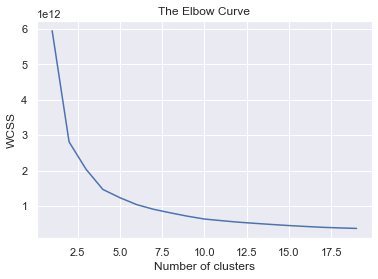

In [93]:
# Plotting an Elbow curve for the same

def elbow_curve(sample = sample):
    wcss = []
    for i in range(1,20):
      kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
      kmeans.fit(sample)
      wcss.append(kmeans.inertia_)
      print('Cluster', i, 'Inertia', kmeans.inertia_)
    plt.plot(range(1,20),wcss)
    plt.title('The Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
    plt.show()

elbow_curve()

In [ ]:
# Unsupervised ML Model -- Extracts features on its own

# Naive Bayes Classifier

In [108]:
# Naive Bayes Model

# Gaussian Process
def GaussianProcess(x,y,parameters=None):
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores=cross_val_score(GaussianProcessClassifier(1.0 * RBF(1.0)), x, y, cv=cv, n_jobs=5, verbose=100)
        model=GaussianProcessClassifier(1.0 * RBF(1.0)).fit(x,y)
        return model

# Naive Bayes Model
def naiveBayes(x,y,parameters=None):
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    scores=cross_val_score(GaussianNB(), x, y, cv=cv, n_jobs=4, verbose=100, scoring='accuracy')
    model=GaussianNB().fit(x,y)
    y_pred = model.predict(x)
    # Create the confusion matrix
    conf_mat = confusion_matrix(y_pred, y, normalize="true")
    return model, conf_mat

# Random Forest Classifier

In [46]:
# RandomForestClassifier
def forest_test(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.25, 
                                                        random_state = 101)
    start_time = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
    print(time.process_time() - start_time)
    predictionforest = trainedforest.predict(X_Test)
    print(n_estimators, ' : ', confusion_matrix(Y_Test,predictionforest))
    print(n_estimators, ' : ', classification_report(Y_Test,predictionforest))




50.78125
[[76  6  0  0  0]
 [14 43  8  0  0]
 [ 0 10 53  0 22]
 [ 0  0  0 62  0]
 [ 0  0  0  0 64]]


NameError: name 'classification_report' is not defined

# SVR Classifier

In [ ]:
#SVR Model

def svr(x,y,parameters):
        print ('Running SVR model')
        models=[]
        test_accs=[]
        test_f1s=[]
        for tr_index, ts_index in StratifiedKFold(n_splits=4, shuffle=True, random_state=42).split(x,y):
            print ('\n\nNew Outer CV\n\n')
            grid = GridSearchCV(SVR(), param_grid=parameters, verbose=100,
                            n_jobs=4, scoring=['neg_mean_squared_error'],refit='neg_mean_squared_error')
            grid.fit(x[tr_index], y[tr_index])
            best_model = grid.best_estimator_
            best_model_preds = best_model.predict(x[ts_index])
            test_acc = mean_squared_error(y[ts_index],best_model_preds)
            models.append(best_model)
            test_accs.append(test_acc)
        best_test_acc = min(test_accs)
        best_test_model = models[test_accs.index(best_test_acc)]
        print ("\n\n Nested CV Results: {0} {1}\n\n".format(np.mean(test_accs), np.std(test_accs)))
        return best_test_model
svr()

# SVM default model

In [119]:
def svm(x,y,parameters):
	print ("Running SVM model")
	#C_range = np.logspace(-2, 10, 13)
	#gamma_range = np.logspace(-9, 3, 13)
	#param_grid = dict(gamma=gamma_range, C=C_range)
	models=[]
	test_accs=[]
	test_f1s=[]
	for tr_index, ts_index in StratifiedKFold(n_splits=4, shuffle=True, random_state=42).split(x,y):
		print ("\n\nNew Outer CV\n\n")	
	#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
		grid = GridSearchCV(SVC(probability=True), param_grid=parameters, verbose=100, 
				n_jobs=4, scoring=['f1_weighted','accuracy'],refit='f1_weighted')
		grid.fit(x[tr_index], y[tr_index])
		best_model = grid.best_estimator_
		best_model_preds = best_model.predict(x[ts_index])
		test_acc = accuracy_score(y[ts_index],best_model_preds)
		test_f1 = f1_score(y[ts_index], best_model_preds, average="weighted")	
		models.append(best_model)
		test_accs.append(test_acc)
		test_f1s.append(test_f1)	
	#non_nested_score=grid.best_score_
	#nested_score = cross_val_score(grid, X=x, y=y, cv=outer_cv)
	#print "Non-nested - Nested: " + str(non_nested_score - nested_score.mean())
	best_test_acc = max(test_accs)
	best_test_model = models[test_accs.index(best_test_acc)]
	print (f'\n\n Nested CV Results: {0} {1} {2} {3}\n\n').format(np.mean(test_accs), np.std(test_accs), np.mean(test_f1s), np.std(test_f1s))
	return best_test_model

In [120]:
svm(a,b, {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']})

Running SVM model


New Outer CV




ValueError: Found input variables with inconsistent numbers of samples: [1334, 1000]

## Getting methane production data:

In [62]:
import pandas as pd
import numpy as np

In [63]:
file = pd.read_excel('./Biogas_Methane_Inhibition_Data.xlsx')

In [64]:
file

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Day 1,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Day 2,Unnamed: 10,100,Unnamed: 12,Unnamed: 13,Unnamed: 14,Day 3,Unnamed: 16
0,NaN,Biogas Production,Error,Methane Inhibited,Error,NaN,NaN,Biogas Production,Error,Methane Inhibited,Error,NaN,NaN,Biogas Production,Error,Methane Inhibited,Error
1,PC,243.33,55.75,68.414501,4.393137,NaN,PC,243.33,55.75,135.997394,6.077892,NaN,PC,243.33,55.75,130.489568,10.89873
2,NC,181.33,27.23,19.529821,1.533201,NaN,NC,181.33,27.23,40.485603,3.776399,NaN,NC,181.33,27.23,41.351527,2.984386
3,TL,168.33,10.41,57.967897,14.577397,NaN,TL,112,3,64.552626,18.389143,NaN,TL,63.67,3.51,35.695382,6.342647
4,TM,160.67,20.03,40.505281,9.108185,NaN,TM,105,4.36,48.057934,3.070957,NaN,TM,61,2,27.133848,5.93206
5,TH,153.33,13.87,56.907218,4.644965,NaN,TH,104.33,1.15,42.706828,9.863196,NaN,TH,57,1,27.237404,7.325356
6,SL,87.33,13.65,26.773666,4.121198,NaN,SL,92,10.82,31.853283,4.823788,NaN,SL,64.33,7.51,27.43991,6.178419
7,SM,73.5,25.94,21.539514,4.564403,NaN,SM,92.67,3.05,39.969003,1.918006,NaN,SM,60,1,26.706948,2.314524
8,SH,123.5,3.61,28.903295,5.320276,NaN,SH,85.33,1.53,34.748659,3.678304,NaN,SH,58.33,3.05,27.790264,2.647783
9,CL,169.67,10.02,61.870269,5.537099,NaN,CL,114.33,5.13,58.248362,4.994843,NaN,CL,45.33,6.11,26.076377,5.192511


In [84]:
samples = file.iloc[1:12,0].to_numpy()

In [85]:
samples

array(['PC', 'NC', 'TL', 'TM', 'TH', 'SL', 'SM', 'SH', 'CL', 'CM', 'CH'],
      dtype=object)

In [66]:
# Biogas production data cleaning

day1 = pd.DataFrame(file.iloc[1:12,1:5]).reset_index(drop=True)
day2 = pd.DataFrame(file.iloc[1:12,7:11]).reset_index(drop=True)
day3 = pd.DataFrame(file.iloc[1:12, 13:17]).reset_index(drop=True)
day4 = pd.DataFrame(file.iloc[15:26,1:5]).reset_index(drop=True)
day5 = pd.DataFrame(file.iloc[15:26,7:11]).reset_index(drop=True)

In [67]:
day1

,Unnamed: 1,Unnamed: 2,Day 1,Unnamed: 4
0,243.33,55.75,68.414501,4.393137
1,181.33,27.23,19.529821,1.533201
2,168.33,10.41,57.967897,14.577397
3,160.67,20.03,40.505281,9.108185
4,153.33,13.87,56.907218,4.644965
5,87.33,13.65,26.773666,4.121198
6,73.5,25.94,21.539514,4.564403
7,123.5,3.61,28.903295,5.320276
8,169.67,10.02,61.870269,5.537099
9,156,1,53.578013,3.947188


In [68]:
# Function to plot methane production from day 1 to day 5 for a particular sample

methane_data = pd.concat([day1.iloc[:,2], day2.iloc[:,2], day3.iloc[:,2], day4.iloc[:,2], day5.iloc[:,2]], axis = 1)

In [ ]:
methane_data.columns = ['day 1','day 2','day 3','day 4','day 5']

In [70]:
methane_data.iloc[6, 4] =  mean(methane_data.iloc[6, :4])

,a,b,c,d,e
0,68.414501,135.997394,130.489568,128.807944,139.91693
1,19.529821,40.485603,41.351527,60.627685,51.148442
2,57.967897,64.552626,35.695382,20.460905,15.983462
3,40.505281,48.057934,27.133848,20.171365,14.755975
4,56.907218,42.706828,27.237404,17.183434,12.67853
5,26.773666,31.853283,27.43991,25.650289,23.221913
6,21.539514,39.969003,26.706948,22.230406,H23*0.453548344282965
7,28.903295,34.748659,27.790264,17.62806,17.309027
8,61.870269,58.248362,26.076377,17.705453,14.847486
9,53.578013,53.059748,24.787242,14.009386,14.330305


ValueError: could not convert string to float: 'H23*0.453548344282965'

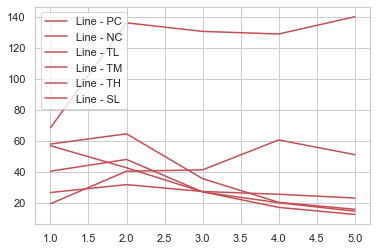

In [87]:
x = list(range(1,6))
for row in range(len(samples)):
    # Plot another line on the same chart/graph
    plt.plot(x, methane_data.iloc[row,:], 'r', label=f'Line - {samples[row]}')
    plt.legend()

plt.show()

range(1, 6)